In [1]:
import numpy as np
# force user to type meaningful name in commandline
name = input('Name of the model:')
epochs = int(input('Number of epochs:'))
batch_size = int(input('Batch Size:'))

In [2]:
#!pip install tensorflow
#!pip install pedalboard
#import soundfile as sf
import tensorflow as tf
#from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
#from tensorflow.keras.activations import tanh, elu, relu
#from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt
#import math
import h5py
import librosa

In [3]:
# EDIT THIS SECTION FOR USER INPUTS

path = 'models/'+name+'_functional/'
audiosource = 'Trial_Data/GuitSigClean_Monophon'

#name = 'Chorus_Test'
if not os.path.exists(path):
    os.makedirs(path)
else:
    print("A model with the same name already exists. Please choose a new name.")
    exit

#epochs = 20
fs = 44100
#batch_size = 4 
test_size = 0.2
input_size = 100

train_mode = 0     # 0 = speed training, 
                   # 1 = accuracy training 
                   # 2 = extended training
if train_mode == 0:         # Speed Training
    learning_rate = 0.01 
    conv1d_strides = 12    
    conv1d_filters = 16
    hidden_units = 36
elif train_mode == 1:       # Accuracy Training (~10x longer than Speed Training)
    learning_rate = 0.01 
    conv1d_strides = 4
    conv1d_filters = 36
    hidden_units= 64
else:                       # Extended Training (~60x longer than Accuracy Training)
    learning_rate = 0.0005 
    conv1d_strides = 3
    conv1d_filters = 36
    hidden_units= 96

In [4]:
class WindowArray(Sequence):
        
    def __init__(self, x, y, window_len, batch_size=32):
        self.x = x
        self.y = y[window_len-1:] 
        self.window_len = window_len
        self.batch_size = batch_size
        
    def __len__(self):
        l = len(self.x)
        return (len(self.x) - self.window_len +1) // self.batch_size
    
    def __getitem__(self, index):
        x_out = np.stack([self.x[idx: idx+self.window_len] for idx in range(index*self.batch_size, (index+1)*self.batch_size)])
        y_out = self.y[index*self.batch_size:(index+1)*self.batch_size]
        return x_out, y_out

def pre_emphasis_filter(x, coeff=0.95):
    return tf.concat([x, x - coeff * x], 1)
    
def error_to_signal(y_true, y_pred): 
    """
    Error to signal ratio with pre-emphasis filter:
    """
    y_true, y_pred = pre_emphasis_filter(y_true), pre_emphasis_filter(y_pred)
    return K.sum(tf.pow(y_true - y_pred, 2), axis=0) / (K.sum(tf.pow(y_true, 2), axis=0) + 1e-10)
    
def save_wav(name, data):
    wavfile.write(name, fs, data.flatten().astype(np.float32))

In [5]:
# reading processed audio and append to dry and wet array
from pathlib import Path
fx_name = 'Chorus'
directory_dry = 'Trial_Data//GuitSigClean_1'
directory_wet = 'Trial_Data//GuitSig_with_' + fx_name
dry = []
wet = []
effect_indices = []
files_dry = Path(directory_dry).glob('*')
files_wet = Path(directory_wet).glob('*')
for filename in files_dry:
    x, samplerate_x = librosa.load(filename, mono=True, sr=fs, duration=1.0, dtype=np.float32)
    dry.append(x)
for filename in files_wet:
    y, samplerate_y = librosa.load(filename, mono=True, sr=fs, duration=1.0, dtype=np.float32)
    wet.append(y)

dry = np.array(dry)
wet = np.array(wet)

In [6]:
# Create Functional Model ###########################################
clear_session()
input_shape = (fs,1)
inputs = tf.keras.Input(shape=input_shape) # 1 second

conv1D_1 = Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation=None, padding='same', input_shape=(input_shape), name='First_1D_Conv')(inputs)
#output_after_1st_layer = conv1D_1(inputs)
output_after_2nd_layer = Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation=None, padding='same', name='Second_1D_Conv')(conv1D_1)
output_after_lstm_layer = LSTM(hidden_units, name='LSTM')(output_after_2nd_layer)

outputs = Dense(fs, activation=None, name='Output')(output_after_lstm_layer)
model_functional_api = tf.keras.Model(inputs=inputs, outputs=outputs, name="functional_model")
model_functional_api.summary()
model_functional_api.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[error_to_signal])

Model: "functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 44100, 1)]        0         
                                                                 
 First_1D_Conv (Conv1D)      (None, 3675, 16)          208       
                                                                 
 Second_1D_Conv (Conv1D)     (None, 307, 16)           3088      
                                                                 
 LSTM (LSTM)                 (None, 36)                7632      
                                                                 
 Output (Dense)              (None, 44100)             1631700   
                                                                 
Total params: 1,642,628
Trainable params: 1,642,628
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Chorus ###########################################

### Custom Form for Functional Model

X_all = dry[:100].astype(np.float32)
print(X_all.shape)
X_all = X_all.reshape(len(X_all),44100, 1)
y_all = wet[:100].astype(np.float32)
y_all = y_all.reshape(len(y_all),44100, 1)
train_examples = int(len(X_all)*0.8)

xtrain, xtest, ytrain, ytest=train_test_split(X_all, y_all, test_size=0.15)

(100, 44100)


In [9]:
# Train Functional Model ###################################################
history = model_functional_api.fit(xtrain, ytrain, epochs=epochs, verbose=1, validation_split=0.2, shuffle=True)    
model_functional_api.save(path+name+'functional_model'+'.h5', overwrite=True)

# Run Prediction #################################################
print("Running prediction..")

val_loss, val_acc = model_functional_api.evaluate(xtrain, ytrain, verbose=2)
print("Loss:", val_loss, " Accuracy:", val_acc)

prediction = model_functional_api.predict(xtest)

save_wav( path+'y_pred.wav', prediction)
save_wav( path+'x_test.wav', xtest)
save_wav( path+'y_test.wav', ytest)

# Add additional data to the saved model (like input_size)
filename = 'models/'+name+'_functional'+'/'+name+'functional_model'+'.h5'
f = h5py.File(filename, 'a')
grp = f.create_group("info")
dset = grp.create_dataset("input_size", (1,), dtype='int16')
dset[0] = input_size
f.close()

Epoch 1/10
3/3 [==============================] - 1s 340ms/step - loss: 0.0207 - error_to_signal: 58.8897 - val_loss: 0.0230 - val_error_to_signal: 32.5182
Epoch 2/10
3/3 [==============================] - 1s 295ms/step - loss: 0.0207 - error_to_signal: 43.7843 - val_loss: 0.0230 - val_error_to_signal: 79.1709
Epoch 3/10
3/3 [==============================] - 1s 313ms/step - loss: 0.0205 - error_to_signal: 81.0754 - val_loss: 0.0230 - val_error_to_signal: 149.2393
Epoch 4/10
3/3 [==============================] - 1s 332ms/step - loss: 0.0203 - error_to_signal: 133.5816 - val_loss: 0.0232 - val_error_to_signal: 191.8264
Epoch 5/10
3/3 [==============================] - 1s 331ms/step - loss: 0.0200 - error_to_signal: 140.6963 - val_loss: 0.0234 - val_error_to_signal: 104.2641
Epoch 6/10
3/3 [==============================] - 1s 356ms/step - loss: 0.0197 - error_to_signal: 66.7948 - val_loss: 0.0237 - val_error_to_signal: 48.6845
Epoch 7/10
3/3 [==============================] - 1s 398ms/

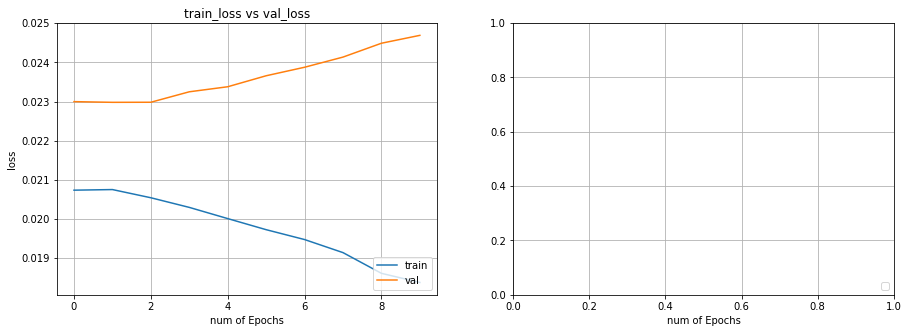

In [10]:
# visualizing losses and accuracy
train_loss, val_loss = history.history['loss'], history.history['val_loss']
#train_acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

# setup plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
 
# plot loss
ax[0].plot(range(epochs), train_loss)
ax[0].plot(range(epochs), val_loss)
ax[0].set_ylabel('loss')
ax[0].set_title('train_loss vs val_loss')

# plot accuracy
#ax[1].plot(range(epochs), train_acc)
#ax[1].plot(range(epochs), val_acc)
#ax[1].set_ylabel('accuracy')
#ax[1].set_title('train_acc vs val_acc')

# plot adjustement
for a in ax:
    a.grid(True)
    a.legend(['train','val'],loc=4)
    a.set_xlabel('num of Epochs')
    
plt.show()